# Data augmentation

Data augmentation is when we modify our images and masks when we load them from files using the dataset object. This process is stochastic, so the images loaded in each training epoch differ slightly.

The main reason one uses data augmentation is to augment the generalization of our model to new images. By changing the images in each training epoch, we force the model to learn more generalizable features instead of learning specific features unique to each labeled image.

With data augmentation, you don't need to label as many images as without data augmentation.

I used the [Albumentations](https://albumentations.ai/) library to implement data augmentation. One can create a pipeline to process our images when they are loaded from files. The library can work with image-mask pairs used for segmentation. 

The normalization of our images (set mean and std of each channel to 0 and 1) can also be performed by the data augmentation pipeline. See the notebook on data normalization.

Below, I am using four transformations. We can set the probability that this transformation is applied using the `p` argument. You can set it in the project configuration file. Alternatively, you can edit the code below.

### Tips

* If you track left/right body parts, you probably don't want to flip your images. This would mean setting 'augmentation_HorizontalFlipProb': 0.0 in your `config.yalm` file.


In [1]:
# this will run the code in the setup_project.py and create a variable called `project`
%run setup_project.py

import albumentations as A
from unetTracker.dataset import UNetDataset

Project directory: /home/kevin/Documents/trackingProjects/finger_tracker
Getting configuration from config file. Values from config file will be used.
Loading /home/kevin/Documents/trackingProjects/finger_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'finger_tracker', 'normalization_values': {'means': [0.40811261534690857, 0.45454299449920654, 0.5159890055656433], 'stds': [0.23983965814113617, 0.25155460834503174, 0.2690598964691162]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['f1', 'f2', 'f3', 'f4'], 'target_radius': 6, 'unet_features': [64, 128, 256, 512]}


In [2]:
original_height = project.image_size[0]
original_width = project.image_size[1]
means = project.normalization_values["means"]
stds = project.normalization_values["stds"]

trainTransform = A.Compose([  
                    A.RandomSizedCrop(min_max_height=(original_height-50, original_height),
                                      w2h_ratio=original_width/original_height,height=original_height, width=original_width, 
                                      p=project.augmentation_RandomSizedCropProb),
                    A.HorizontalFlip(p=project.augmentation_HorizontalFlipProb),
                    A.Rotate (limit=30,border_mode=cv2.BORDER_CONSTANT,p=project.augmentation_RotateProb),
                  
                    A.Normalize(mean=means, std=stds)
])

valTransform = A.Compose([   
                    A.Normalize(mean=means, std=stds)
])


print(trainTransform)
print(valTransform)

Compose([
  RandomSizedCrop(always_apply=False, p=1.0, min_max_height=(220, 270), height=270, width=480, w2h_ratio=1.7777777777777777, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.0),
  Rotate(always_apply=False, p=0.3, limit=(-30, 30), interpolation=1, border_mode=0, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
  Normalize(always_apply=False, p=1.0, mean=[0.40811261534690857, 0.45454299449920654, 0.5159890055656433], std=[0.23983965814113617, 0.25155460834503174, 0.2690598964691162], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.40811261534690857, 0.45454299449920654, 0.5159890055656433], std=[0.23983965814113617, 0.25155460834503174, 0.2690598964691162], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


We don't want to apply data augmentation on the validation set. 

We can save the transformation in a `augmentation` directory inside our project directory.

We will be able to load the data augmentation pipeline from files when training the model.

In [3]:
project.augmentation_dir
if os.path.exists(project.augmentation_dir) == False:
    os.mkdir(project.augmentation_dir)

In [4]:
fileName = os.path.join(project.augmentation_dir,"trainTransform")
print("Saving trainTransform as", fileName)
pickle.dump( trainTransform, open( fileName, "wb" ))


Saving trainTransform as /home/kevin/Documents/trackingProjects/finger_tracker/augmentation/trainTransform


In [5]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Saving trainTransform as", fileName)
pickle.dump( valTransform, open( fileName, "wb" ))


Saving trainTransform as /home/kevin/Documents/trackingProjects/finger_tracker/augmentation/valTransform


## Visualize the effect of data augmentation

We can create two datasets pointing to the same directory. Only one dataset will perform data augmentation. We can then compare the image with and without data augmentation.

In [6]:
train_image_dir = os.path.join(project.dataset_dir,"train_images")
train_mask_dir =  os.path.join(project.dataset_dir,"train_masks")
train_coordinate_dir = os.path.join(project.dataset_dir,"train_coordinates")
dataset_noAugmentation = UNetDataset(image_dir=train_image_dir,
                           mask_dir=train_mask_dir,
                           coordinate_dir=train_coordinate_dir,
                           transform=valTransform, # we pass our transform function to the UNetDataset object
                           image_extension=project.image_extension)
dataset_withAugmentation = UNetDataset(image_dir=train_image_dir,
                           mask_dir=train_mask_dir,
                           coordinate_dir=train_coordinate_dir,
                           transform=trainTransform, # we pass our transform function to the UNetDataset object
                           image_extension=project.image_extension)

In [7]:
imageNoAugmentation, _, _ = dataset_noAugmentation[0]
imageWithAugmentation, _, _ = dataset_withAugmentation[0]

In [8]:
imageNoAugmentation.mean(),imageWithAugmentation.mean()

(tensor(0.0568), tensor(-0.3069))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

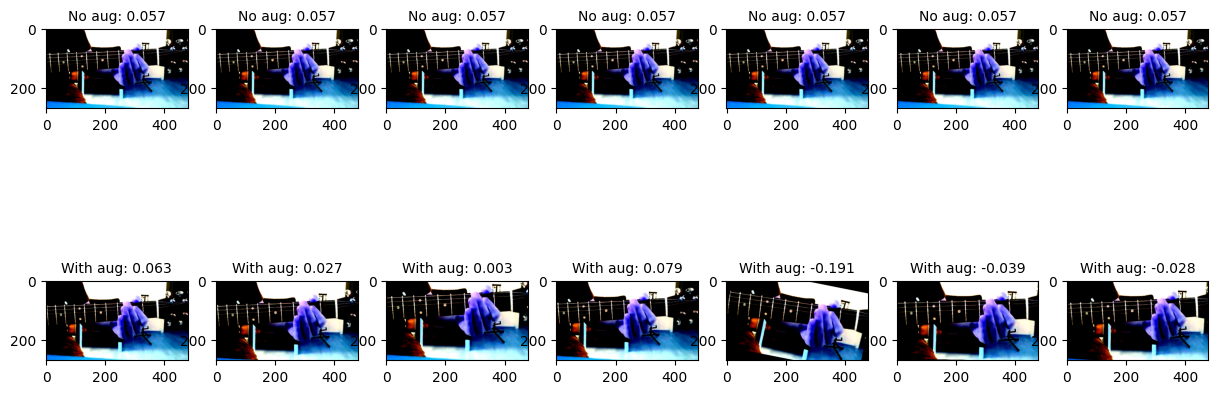

In [9]:
fig, axs = plt.subplots(2, 7,figsize=(15,6))
for i in range(7):
    imageNoAugmentation, _, _ = dataset_noAugmentation[0]
    imageWithAugmentation, _, _ = dataset_withAugmentation[0]
    axs[0,i].imshow(imageNoAugmentation.permute(1,2,0))
    axs[0,i].set_title("No aug: {:.3f}".format(imageNoAugmentation.mean().item()),fontsize=10)
    axs[1,i].imshow(imageWithAugmentation.permute(1,2,0))
    axs[1,i].set_title("With aug: {:.3f}".format(imageWithAugmentation.mean().item()),fontsize=10)